## <span style="color:#db7d60">Setup</span>

Import dependencies

In [1]:
import json
import math
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pUtil
import textwrap
from IPython.display import display
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

This block defines functions used across the whole of this file.

In [2]:
def get_model_data_columns():
    return [
        'model_name',
        # Metadata (dataset information)
        'vocab_size',
        'max_sequence_length',
        'num_train_tokens',
        'num_val_tokens',
        # Configuration information
        'batch_size',
        'learning_rate',
        'min_lr',
        'lr_decay_iters',
        'n_layer',
        'n_head',
        'n_embd',
        'scheme',
        'preparation_name',
        # Training information
        "iters_trained",
        'min_saved_train_loss',
        'min_saved_val_loss'
    ]

# iterations_per_epoch must be provided for epoch calculations
def get_training_data_for_model(model_name, iterations_per_epoch=-1):
    training_log_filename = pUtil.get_training_dir(model_name) / "train_log_1.jsonl"
    
    running_data, saved_data = [], []
    with open(training_log_filename) as training_log_file:
        for jline in training_log_file:
            jdata = json.loads(jline)
            if jdata.get("message") == "Training progress" and "iter" in jdata:
                current_epochs_trained = 0 if jdata['iter'] == 0 else (jdata['iter'] / iterations_per_epoch)
                running_data.append({'iter': jdata["iter"], 'epoch': current_epochs_trained, 'train_loss': jdata["train_loss"], 'val_loss': jdata["val_loss"]})
            elif jdata.get("message") == "Training progress: checking checkpoint conditions":
                current_epochs_trained = 0 if jdata['step'] == 0 else (jdata['step'] / iterations_per_epoch)
                saved_data.append({'iter': jdata["step"], 'epoch': current_epochs_trained, 'train_loss': jdata["train_loss"], 'val_loss': jdata["val_loss"]})
    
    return pd.DataFrame(running_data), pd.DataFrame(saved_data)

# Returns all important data for a model in a dictionary
def get_all_data_for_model(model_name):
    meta_filename = pUtil.get_model_meta_filename(model_name)
    config_filename = pUtil.get_model_config_filename(model_name)
    
    if not meta_filename.exists():
        return
    
    # Metadata (dataset information)
    with open(meta_filename, 'rb') as meta_file:
        meta_data = pickle.load(meta_file)
        vocab_size = meta_data["vocab_size"]
        max_sequence_length = meta_data['max_sequence_length']
        num_train_tokens = meta_data['num_train_tokens']
        num_train_tokens = meta_data['num_val_tokens']

    # Configuration information
    with open(config_filename, 'r') as config_file:
        config = json.load(config_file)
        training_config = config.get('training_config', {})
        batch_size = training_config.get('batch_size', -1)
        block_size = training_config.get('block_size', -1)
        context_events = training_config.get('context_events', -1)
        learning_rate = training_config.get('learning_rate', -1)
        min_lr = training_config.get('min_lr', -1)
        lr_decay_iters = training_config.get('lr_decay_iters', -1)
        n_layer = training_config.get('n_layer', -1)
        n_head = training_config.get('n_head', -1)
        n_embd = training_config.get('n_embd', -1)
        scheme = training_config.get('scheme', 'standard')
        preparation_name = training_config.get('preparation_name', 'unknown')
        
        if block_size == -1:
            block_size = context_events * max_sequence_length
        
        iterations_per_epoch = num_train_tokens // (batch_size * block_size)
    
    # Training information
    running_df, saved_df = get_training_data_for_model(model_name, iterations_per_epoch)      
    
    iters_trained = running_df['iter'].max()
    min_saved_val_loss_row = saved_df.loc[saved_df['val_loss'].idxmin()]
    
    return {
        'model_name': model_name,
        # Metadata (dataset information)
        'vocab_size': vocab_size,
        'max_sequence_length': max_sequence_length,
        'num_train_tokens': num_train_tokens,
        'num_val_tokens': num_train_tokens,
        # Configuration information
        'batch_size': batch_size,
        'block_size': block_size,
        'learning_rate': learning_rate,
        'min_lr': min_lr,
        'lr_decay_iters': lr_decay_iters,
        'n_layer': n_layer,
        'n_head': n_head,
        'n_embd': n_embd,
        'scheme': scheme,
        'preparation_name': preparation_name,
        # Training information
        "iters_trained": iters_trained,
        'min_saved_train_loss': min_saved_val_loss_row['train_loss'],
        'min_saved_val_loss': min_saved_val_loss_row['val_loss']
    }

# Returns a DataFrame with all the important data for all models
def get_default_df(model_names):
    columns = get_model_data_columns()
    model_data_list = [row for name in model_names if (row := get_all_data_for_model(name)) is not None]
    model_data_df = pd.DataFrame(model_data_list, columns=columns)
    return model_data_df

Plotting functions

In [3]:
def plot_model_train_data(model_name, ax=None, use_epochs=True, y_lim=None, use_log_scale=True):
    """
    Plots training and validation loss for a single model.
    """
    model_data = get_all_data_for_model(model_name)
    iterations_per_epoch = model_data['num_train_tokens'] // (model_data['batch_size'] * model_data['block_size'])

    running_df, saved_df = get_training_data_for_model(model_name, iterations_per_epoch)
    metric = 'epoch' if use_epochs else 'iter'

    min_val_row = saved_df.loc[saved_df['val_loss'].idxmin()]

    ax = ax or plt
    
    # Plot training and validation loss
    train_line, = ax.plot(running_df[metric], running_df['train_loss'], label=f'Training Loss ({model_name})', linewidth=0.5)
    val_line, = ax.plot(running_df[metric], running_df['val_loss'], label=f'Validation Loss ({model_name})', color=train_line.get_color(), linestyle='--', linewidth=0.5)

    # Mark the point of minimum validation loss
    ax.scatter(min_val_row[metric], min_val_row['train_loss'], label=f'Min Train Loss ({model_name}; {min_val_row["train_loss"]:.4f})', color=train_line.get_color(), edgecolors='black')
    ax.scatter(min_val_row[metric], min_val_row['val_loss'], label=f'Min Val Loss ({model_name}; {min_val_row["val_loss"]:.4f})', color=train_line.get_color(), edgecolors='black', marker='s', s=50)

    # Annotate the line with the model name
    final_row = running_df.iloc[-1]
    ax.annotate(model_name, xy=(final_row['iter'], final_row['val_loss']), xytext=(final_row['iter'] * 1.005, final_row['val_loss'] - 0.02), fontsize=9, color=val_line.get_color())

    # Format axes if it's a subplot
    if ax is not plt:
        ax.set_xlabel(metric.capitalize())
        ax.set_ylabel('Loss')
        ax.set_title(model_name)
        if y_lim:
            ax.set_ylim(y_lim)
        if use_log_scale:
            ax.set_yscale('log', base=10)
        ax.legend()
    
def plot_train_graphs(models_to_compare, juxtaposed=True, use_epochs=True, y_lim=None, use_log_scale=True):
    """
    Plots training graphs for multiple models, either side-by-side or overlaid.
    """
    num_models = len(models_to_compare)
    share_axes = juxtaposed and num_models > 1

    if share_axes:
        cols = min(num_models, 3)
        rows = math.ceil(num_models / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 6 * rows), sharex=False, sharey=True)
        axes = np.ravel(axes)
    else:
        fig, axes = plt.figure(figsize=(15, 6)), [None] * num_models

    for model_name, ax in zip(models_to_compare, axes):
        plot_model_train_data(model_name, ax=ax, use_epochs=use_epochs, y_lim=y_lim, use_log_scale=use_log_scale)

    # Add title and format global figure
    full_title = f"Training Progress for {', '.join(models_to_compare)}"
    if share_axes:
        fig.suptitle(full_title)
        plt.tight_layout()
    else:
        plt.title("\n".join(textwrap.wrap(full_title, width=60)))
        if use_log_scale:
            plt.yscale('log', base=10)
        plt.xlabel('Iteration' if not use_epochs else 'Epoch')
        plt.ylabel('Loss')
        if y_lim:
            plt.ylim(y_lim)
        plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

columns = ["num_particles", "pdgid", "e", "px", "py", "pz", "eta", "theta", "phi"]

def get_common_data(model_name):
    dictionary_filename = pUtil.get_model_preparation_dir(model_name) / 'dictionary.json'
    real_leading_test_particles_filename = pUtil.get_model_preparation_dir(model_name) / 'real_leading_test_particles.csv'
    sampled_leading_particles_filename = pUtil.get_latest_sampling_dir(model_name) / 'sampled_leading_particles.csv'

    with open(dictionary_filename) as dictionary_file:
        dictionary = json.load(dictionary_file)

    # Convenience dictionary definitions
    def type_min(column_name):
        return dictionary[f'{column_name}_bin_data']["min"]
    def type_max(column_name):
        return dictionary[f'{column_name}_bin_data']["max"]
    def type_range(column_name):
        return dictionary[f'{column_name}_bin_data']["max"] - dictionary[f'{column_name}_bin_data']["min"]
    p_bin_count = int(type_range('e') // 1000)
    e_bin_count = int(type_range('e') // dictionary["e_bin_data"]["step_size"])
    eta_bin_count = int(type_range('eta') // dictionary["eta_bin_data"]["step_size"])
    theta_bin_count = int(type_range('theta') // dictionary["theta_bin_data"]["step_size"])
    phi_bin_count = int(type_range('phi') // dictionary["phi_bin_data"]["step_size"])
            
    bin_settings = {
        "num_particles": { "min": 0,                 "max": 50,                "bins": 50 },
        "e":             { "min": type_min('e'),     "max": type_max('e'),     "bins": e_bin_count },
        "px":            { "min": type_min('e'),     "max": type_max('e'),     "bins": p_bin_count },
        "py":            { "min": type_min('e'),     "max": type_max('e'),     "bins": p_bin_count },
        "pz":            { "min": type_min('e'),     "max": type_max('e'),     "bins": p_bin_count },
        "eta":           { "min": type_min('eta'),   "max": type_max('eta'),   "bins": eta_bin_count },
        "theta":         { "min": type_min('theta'), "max": type_max('theta'), "bins": theta_bin_count },
        "phi":           { "min": type_min('phi'),   "max": type_max('phi'),   "bins": phi_bin_count },
    }

    real_df = pd.read_csv(real_leading_test_particles_filename, sep=" ", names=columns, engine="c", header=None)
    sampled_df = pd.read_csv(sampled_leading_particles_filename, sep=" ", names=columns, engine="c", header=None)
    return bin_settings, real_df, sampled_df

def plot_model_distributions(model_name, column_name, ax=None):
    bin_settings, real_df, sampled_df = get_common_data(model_name)
    
    min_val = bin_settings[column_name]['min']
    max_val = bin_settings[column_name]['max']
    bins = bin_settings[column_name]['bins']
    
    real_df_weights = np.ones_like(real_df[column_name]) / len(real_df[column_name])
    sampled_df_weights = np.ones_like(sampled_df[column_name]) / len(sampled_df[column_name])
    
    ax = ax or plt
    ax.hist(real_df[column_name], bins=bins, weights=real_df_weights, range=(min_val, max_val), alpha=0.7, color="blue", label=f'Input ({model_name})')
    ax.hist(sampled_df[column_name], bins=bins, weights=sampled_df_weights, range=(min_val, max_val), alpha=0.7, color="orange", label=f'Sampled ({model_name})')
    if ax is not plt:
        ax.set_xlabel(column_name)
        ax.set_ylabel('Frequency (Normalized)')
        ax.set_title(f'{model_name}')
        ax.legend()

def compare_distributions(models_to_compare, column_name, juxtaposed=True, dists_per_row=3):
    if juxtaposed:
        num_horizontal, num_vertical = min(len(models_to_compare), dists_per_row), (math.ceil(len(models_to_compare) / dists_per_row))
        figure, axes = plt.subplots(num_vertical, num_horizontal, figsize=(8 * num_horizontal, 6 * num_vertical), sharex=False, sharey=True)
        if len(models_to_compare) == 1:
            axes = [axes]
        axes = np.atleast_1d(axes).flatten()
        for model_name, ax in zip(models_to_compare, axes):
            plot_model_distributions(model_name, column_name=column_name, ax=ax)
        figure.suptitle(f'Training Progress for {", ".join(models_to_compare)}')
        plt.tight_layout()
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()
    else:
        plt.figure(figsize=(15, 6))
        for model_name in models_to_compare:
            plot_model_distributions(model_name, column_name=column_name)
        plt.title(f'Training Progress for {", ".join(models_to_compare)}')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(axis="y", linestyle="--", alpha=0.7)

## <span style="color:#db7d60">Comparisions</span>

In [5]:
def get_train_data_columns():
    return [
        'model_name',
        # Metadata (dataset information)
        'vocab_size',
        'max_sequence_length',
        'num_train_tokens',
        'num_val_tokens',
        # Configuration information
        'batch_size',
        'learning_rate',
        'min_lr',
        'lr_decay_iters',
        'n_layer',
        'n_head',
        'n_embd',
        'scheme',
        'preparation_name',
        # Training information
        "iters_trained",
        'min_saved_train_loss',
        'min_saved_val_loss'
    ]

def get_default_df(model_names):
    columns = get_train_data_columns()
    model_data_list = [row for name in model_names if (row := get_train_data_as_row(name)) is not None]
    model_data_df = pd.DataFrame(model_data_list, columns=columns)
    return model_data_df

def get_train_data_as_row(model_name):
    training_log_filename = pUtil.get_training_dir(model_name) / "train_log_1.jsonl"
    meta_filename = pUtil.get_model_meta_filename(model_name)
    config_filename = pUtil.get_model_config_filename(model_name)
    
    if not meta_filename.exists():
        return None
    
    with open(meta_filename, 'rb') as meta_file:
        meta_data = pickle.load(meta_file)
        vocab_size = meta_data["vocab_size"]
        max_sequence_length = meta_data['max_sequence_length']
        num_train_tokens = meta_data['num_train_tokens']
        num_train_tokens = meta_data['num_val_tokens']

    with open(config_filename, 'r') as config_file:
        config = json.load(config_file)
        training_config = config.get('training_config', {})
        batch_size = training_config.get('batch_size', -1)
        block_size = training_config.get('block_size', -1)
        context_events = training_config.get('context_events', -1)
        learning_rate = training_config.get('learning_rate', -1)
        min_lr = training_config.get('min_lr', -1)
        lr_decay_iters = training_config.get('lr_decay_iters', -1)
        n_layer = training_config.get('n_layer', -1)
        n_head = training_config.get('n_head', -1)
        n_embd = training_config.get('n_embd', -1)
        scheme = training_config.get('scheme', 'standard')
        preparation_name = training_config.get('preparation_name', 'unknown')
        
        if block_size == -1:
            block_size = context_events * max_sequence_length
        
        iterations_per_epoch = num_train_tokens // (batch_size * block_size)
        
    running_data, saved_data = [], []
    with open(training_log_filename) as training_log_file:
        for jline in training_log_file:
            jdata = json.loads(jline)
            if jdata.get("message") == "Training progress" and "iter" in jdata:
                current_epochs_trained = 0 if jdata['iter'] == 0 else (jdata['iter'] / iterations_per_epoch)
                running_data.append({'iter': jdata["iter"], 'epoch': current_epochs_trained, 'train_loss': jdata["train_loss"], 'val_loss': jdata["val_loss"]})
            elif jdata.get("message") == "Training progress: checking checkpoint conditions":
                current_epochs_trained = 0 if jdata['step'] == 0 else (jdata['step'] / iterations_per_epoch)
                saved_data.append({'iter': jdata["step"], 'epoch': current_epochs_trained, 'train_loss': jdata["train_loss"], 'val_loss': jdata["val_loss"]})
                
    running_df = pd.DataFrame(running_data)
    saved_df = pd.DataFrame(saved_data)
    
    iters_trained = running_df['iter'].max()
    min_saved_val_loss_row = saved_df.loc[saved_df['val_loss'].idxmin()]
    
    return {
        'model_name': model_name,
        # Metadata (dataset information)
        'vocab_size': vocab_size,
        'max_sequence_length': max_sequence_length,
        'num_train_tokens': num_train_tokens,
        'num_val_tokens': num_train_tokens,
        # Configuration information
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'min_lr': min_lr,
        'lr_decay_iters': lr_decay_iters,
        'n_layer': n_layer,
        'n_head': n_head,
        'n_embd': n_embd,
        'scheme': scheme,
        'preparation_name': preparation_name,
        # Training information
        "iters_trained": iters_trained,
        'min_saved_train_loss': min_saved_val_loss_row['train_loss'],
        'min_saved_val_loss': min_saved_val_loss_row['val_loss']
    }

#### Comparing different learning rates and their effect on validation loss and the model distributions

In [ ]:
models_to_compare = ['model_5_3_1', 'model_5_3_2', 'model_5_3_3', 'model_5_3_4', 'model_5_3_5', 'model_5_3_6', 'model_5_3_7', 'model_5_3_8', 'model_5_3_9', 'model_5_3_10', 'model_5_3_11', 'model_5_3_12',]
df = get_default_df(models_to_compare)
df = df.sort_values(by='min_saved_val_loss')

# Calculate log10 values for the logarithmic plot
df['learning_rate_log10'] = np.log10(df['learning_rate'])
df['min_lr_log10'] = np.log10(df['min_lr'])

# Table
display(df)

In [ ]:
min_val_loss_row = df.loc[df['min_saved_val_loss'].idxmin()]

# Normal plot
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(1, 2, 1, projection='3d')
scatter = ax.scatter(df['learning_rate'], df['min_lr'], df['min_saved_val_loss'], c=df['min_saved_val_loss'], cmap='viridis', s=60)
ax.scatter([min_val_loss_row['learning_rate']], [min_val_loss_row['min_lr']], [min_val_loss_row['min_saved_val_loss']], color='red', s=100, label=f'Best Model: {min_val_loss_row["model_name"]}')
for x, y, z, label in zip(df['learning_rate'], df['min_lr'], df['min_saved_val_loss'], df['model_name']):
    ax.text(x, y, z, label, size=8)
ax.set_xlabel('learning_rate')
ax.set_ylabel('min_lr')
ax.set_zlabel('min_saved_val_loss')
fig.colorbar(scatter, ax=ax, label='Min Val Loss')
ax.legend()

# Log plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
scatter = ax.scatter(df['learning_rate_log10'], df['min_lr_log10'], df['min_saved_val_loss'], c=df['min_saved_val_loss'], cmap='viridis', s=60)
ax.scatter([min_val_loss_row['learning_rate_log10']], [min_val_loss_row['min_lr_log10']], [min_val_loss_row['min_saved_val_loss']], color='red', s=100, label=f'Best Model: {min_val_loss_row["model_name"]}')
for x, y, z, label in zip(df['learning_rate_log10'], df['min_lr_log10'], df['min_saved_val_loss'], df['model_name']):
    ax.text(x, y, z, label, size=8)
ax.set_xlabel('log10(learning_rate)')
ax.set_ylabel('log10(min_lr)')
ax.set_zlabel('min_saved_val_loss')
fig.colorbar(scatter, ax=ax, label='Min Val Loss')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Training graphs
plot_train_graphs(models_to_compare, juxtaposed=False, use_epochs=False, use_log_scale=True)
models_to_compare = ['model_5_3_9', 'model_5_3_10', 'model_5_3_12']
plot_train_graphs(models_to_compare, juxtaposed=False, use_epochs=False, y_lim=[0.78, 0.85], use_log_scale=True)

In [ ]:
# models_to_compare = ['model_5_3_1', 'model_5_3_2', 'model_5_3_3', 'model_5_3_4', 'model_5_3_5', 'model_5_3_6', 'model_5_3_7', 'model_5_3_8', 'model_5_3_9', 'model_5_3_10', 'model_5_3_11', 'model_5_3_12']
models_to_compare = ['model_5_3_8', 'model_5_3_9', 'model_5_3_10', 'model_5_3_12']
for column in columns:
    if column == 'pdgid':
        continue
    compare_distributions(models_to_compare, column_name=column, juxtaposed=True, dists_per_row=5)

#### Comparing different number of layers and their effect on validation loss and model distributions

In [ ]:
models_to_compare = ['model_5_3_13', 'model_5_3_14', 'model_5_3_15', 'model_5_3_16', 'model_5_3_17', 'model_5_3_18']
df = get_default_df(models_to_compare)
df = df.sort_values(by='min_saved_val_loss')

# Calculate log10 values for the logarithmic plot
df['learning_rate_log10'] = np.log10(df['learning_rate'])
df['min_lr_log10'] = np.log10(df['min_lr'])

# Table
display(df)

In [ ]:
min_val_loss_row = df.loc[df['min_saved_val_loss'].idxmin()]

# Normal plot
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(1, 2, 1, projection='3d')
scatter = ax.scatter(df['learning_rate'], df['min_lr'], df['min_saved_val_loss'], c=df['min_saved_val_loss'], cmap='viridis', s=60)
ax.scatter([min_val_loss_row['learning_rate']], [min_val_loss_row['min_lr']], [min_val_loss_row['min_saved_val_loss']], color='red', s=100, label=f'Best Model: {min_val_loss_row["model_name"]}')
for x, y, z, label in zip(df['learning_rate'], df['min_lr'], df['min_saved_val_loss'], df['model_name']):
    ax.text(x, y, z, label, size=8)
ax.set_xlabel('learning_rate')
ax.set_ylabel('min_lr')
ax.set_zlabel('min_saved_val_loss')
fig.colorbar(scatter, ax=ax, label='Min Val Loss')
ax.legend()

# Log plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
scatter = ax.scatter(df['learning_rate_log10'], df['min_lr_log10'], df['min_saved_val_loss'], c=df['min_saved_val_loss'], cmap='viridis', s=60)
ax.scatter([min_val_loss_row['learning_rate_log10']], [min_val_loss_row['min_lr_log10']], [min_val_loss_row['min_saved_val_loss']], color='red', s=100, label=f'Best Model: {min_val_loss_row["model_name"]}')
for x, y, z, label in zip(df['learning_rate_log10'], df['min_lr_log10'], df['min_saved_val_loss'], df['model_name']):
    ax.text(x, y, z, label, size=8)
ax.set_xlabel('log10(learning_rate)')
ax.set_ylabel('log10(min_lr)')
ax.set_zlabel('min_saved_val_loss')
fig.colorbar(scatter, ax=ax, label='Min Val Loss')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Training graphs
plot_train_graphs(models_to_compare, juxtaposed=False, use_epochs=False, use_log_scale=True)
plot_train_graphs(models_to_compare, juxtaposed=False, use_epochs=False, y_lim=[0.78, 0.85], use_log_scale=True)

In [ ]:
models_to_compare = ['model_5_3_13', 'model_5_3_14', 'model_5_3_15', 'model_5_3_17', 'model_5_3_18']
for column in columns:
    if column == 'pdgid':
        continue
    compare_distributions(models_to_compare, column_name=column, juxtaposed=True, dists_per_row=5)

#### Investigating the broken eta distribution

In [ ]:
import csv

columns = ["num_particles", "pdgid", "e", "px", "py", "pz", "eta", "theta", "phi"]

def get_common_data(model_name):
    dictionary_filename = pUtil.get_model_preparation_dir(model_name) / 'dictionary.json'
    # real_leading_test_particles_filename = pUtil.get_model_preparation_dir(model_name) / 'real_leading_test_particles.csv'
    real_leading_test_particles_filename = pUtil.get_temp_dir() / 'real_leading_test_particles.txt'
    sampled_leading_particles_filename = pUtil.get_latest_sampling_dir(model_name) / 'sampled_leading_particles.csv'

    with open(dictionary_filename) as dictionary_file:
        dictionary = json.load(dictionary_file)

    # Convenience dictionary definitions
    p_bin_count = (dictionary["e_bin_data"]["max"] - dictionary["e_bin_data"]["min"]) // 1000
    e_bin_count = (dictionary["e_bin_data"]["max"] - dictionary["e_bin_data"]["min"]) // dictionary["e_bin_data"]["step_size"]
    eta_bin_count = int((dictionary["eta_bin_data"]["max"] - dictionary["eta_bin_data"]["min"]) // dictionary["eta_bin_data"]["step_size"])
            
    bin_settings = {
        "num_particles": { "min": 0,                                 "max": 50,                                "bins": 50 },
        "e":             { "min": dictionary["e_bin_data"]["min"],   "max": dictionary["e_bin_data"]["max"],   "bins": e_bin_count },
        "px":            { "min": dictionary["e_bin_data"]["min"],   "max": dictionary["e_bin_data"]["max"],   "bins": p_bin_count },
        "py":            { "min": dictionary["e_bin_data"]["min"],   "max": dictionary["e_bin_data"]["max"],   "bins": p_bin_count },
        "pz":            { "min": dictionary["e_bin_data"]["min"],   "max": dictionary["e_bin_data"]["max"],   "bins": p_bin_count },
        "eta":           { "min": dictionary["eta_bin_data"]["min"], "max": dictionary["eta_bin_data"]["max"], "bins": eta_bin_count },
        "theta":         { "min": -2 * np.pi,                        "max": 2 * np.pi,                         "bins": int((4 * np.pi) // dictionary["theta_bin_data"]["step_size"]) },
        "phi":           { "min": -2 * np.pi,                        "max": 2 * np.pi,                         "bins": int((4 * np.pi) // dictionary["phi_bin_data"]["step_size"]) },
    }

    df1 = pd.read_csv(real_leading_test_particles_filename, sep=" ", names=columns, engine="c", header=None)
    df2 = pd.read_csv(sampled_leading_particles_filename, sep=" ", names=columns, engine="c", header=None)
    return bin_settings, df1, df2

def generate_distributions(model_name, column_name, ax=None):
    bin_settings, df1, df2 = get_common_data(model_name)
    
    min_val = bin_settings[column_name]['min']
    max_val = bin_settings[column_name]['max']
    bins = bin_settings[column_name]['bins']
    
    df1_weights = np.ones_like(df1[column_name]) / len(df1[column_name])
    df2_weights = np.ones_like(df2[column_name]) / len(df2[column_name])
    
    ax = ax or plt
    ax.hist(df1[column_name], bins=bins, weights=df1_weights, range=(min_val, max_val), edgecolor="black", alpha=0.7, color="blue", label=f'Input ({model_name})')
    ax.hist(df2[column_name], bins=bins, weights=df2_weights, range=(min_val, max_val), edgecolor="black", alpha=0.7, color="orange", label=f'Sampled ({model_name})')
    if ax is not plt:
        ax.set_xlabel(column_name)
        ax.set_ylabel('Frequency (Normalized)')
        ax.set_title(f'{model_name}')
        ax.legend()

def compare_distributions(models_to_compare, column_name, juxtaposed=True, dists_per_row=3):
    if juxtaposed:
        num_horizontal, num_vertical = min(len(models_to_compare), dists_per_row), (math.ceil(len(models_to_compare) / dists_per_row))
        figure, axes = plt.subplots(num_vertical, num_horizontal, figsize=(8 * num_horizontal, 6 * num_vertical), sharex=False, sharey=True)
        if len(models_to_compare) == 1:
            axes = [axes]
        axes = np.atleast_1d(axes).flatten()
        for model_name, ax in zip(models_to_compare, axes):
            generate_distributions(model_name, column_name=column_name, ax=ax)
        figure.suptitle(f'Training Progress for {", ".join(models_to_compare)}')
        plt.tight_layout()
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()
    else:
        plt.figure(figsize=(15, 6))
        for model_name in models_to_compare:
            generate_distributions(model_name, column_name=column_name)
        plt.title(f'Training Progress for {", ".join(models_to_compare)}')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(axis="y", linestyle="--", alpha=0.7)

models_to_compare = ['model_5_2_1']
for column in columns:
    if column == 'pdgid':
        continue
    compare_distributions(models_to_compare, column_name=column, juxtaposed=True, dists_per_row=5)

The eta distribution seems to be fine. There is something about the tokenizer that creates the brokenness in the distributions.
Furthermore this shows we should probably start comparing tokenized to tokenized not real to tokenized.

#### Comparing different tokenization schemes

,model_name,vocab_size,max_sequence_length,num_train_tokens,num_val_tokens,batch_size,learning_rate,min_lr,lr_decay_iters,n_layer,n_head,n_embd,scheme,preparation_name,iters_trained,min_saved_train_loss,min_saved_val_loss
52,model_5_5_1,2185,207,203304429,203304429,64,0.0010,0.000010,100000,24,16,1024,no_particle_boundaries,preparation_5_5,4300,1.160691,1.160160
53,model_5_5_2,2185,207,203304429,203304429,12,0.0010,0.000010,10000,6,8,512,no_particle_boundaries,preparation_5_5,28170,1.150687,1.143499
54,model_5_5_3,2185,207,203304429,203304429,12,0.0010,0.000010,10000,24,16,512,no_particle_boundaries,preparation_5_5,18660,1.143717,1.131610
55,model_5_5_4,2185,207,203304429,203304429,12,0.0010,0.000010,10000,6,8,512,no_particle_boundaries,preparation_5_5,16990,1.156089,1.141705
56,model_5_5_5,2185,207,203304429,203304429,12,0.0010,0.000010,10000,24,16,512,no_particle_boundaries,preparation_5_5,16520,2.793024,2.792834
57,model_5_5_6,2185,207,203304429,203304429,12,0.0001,0.000001,10000,6,8,512,no_particle_boundaries,preparation_5_5,11120,2.865360,2.855707


,model_name,vocab_size,max_sequence_length,num_train_tokens,num_val_tokens,batch_size,learning_rate,min_lr,lr_decay_iters,n_layer,n_head,n_embd,scheme,preparation_name,iters_trained,min_saved_train_loss,min_saved_val_loss
58,model_5_6_1,2185,289,283840483,283840483,12,0.0010,0.000010,10000,6,8,512,paddingv2,preparation_5_6,20970,2.032584,2.033979
59,model_5_6_2,2185,289,283840483,283840483,12,0.0010,0.000010,10000,6,8,512,paddingv2,preparation_5_6,38430,0.832812,0.823385
60,model_5_6_3,2185,289,283840483,283840483,12,0.0100,0.001000,10000,6,8,512,paddingv2,preparation_5_6,6430,2.277452,2.276101
61,model_5_6_4,2185,289,283840483,283840483,12,0.0001,0.000001,10000,6,8,512,paddingv2,preparation_5_6,28070,2.063275,2.063042


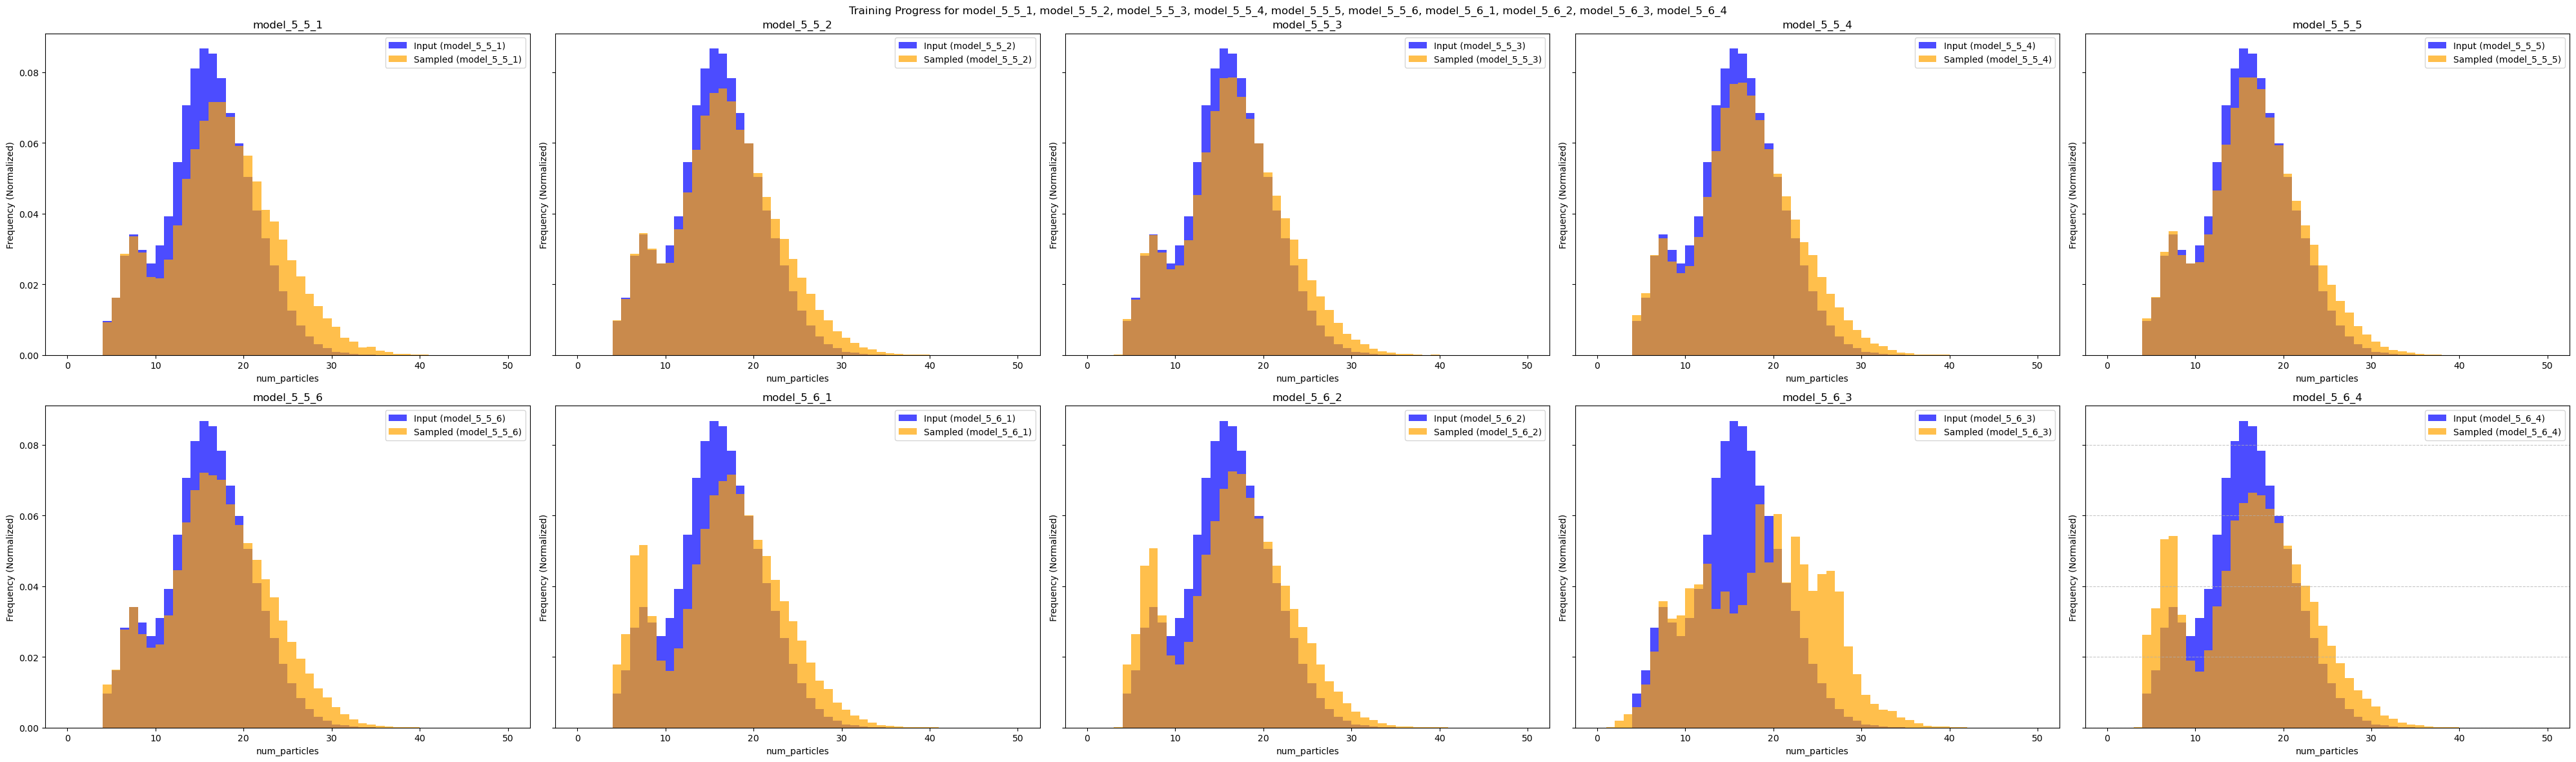

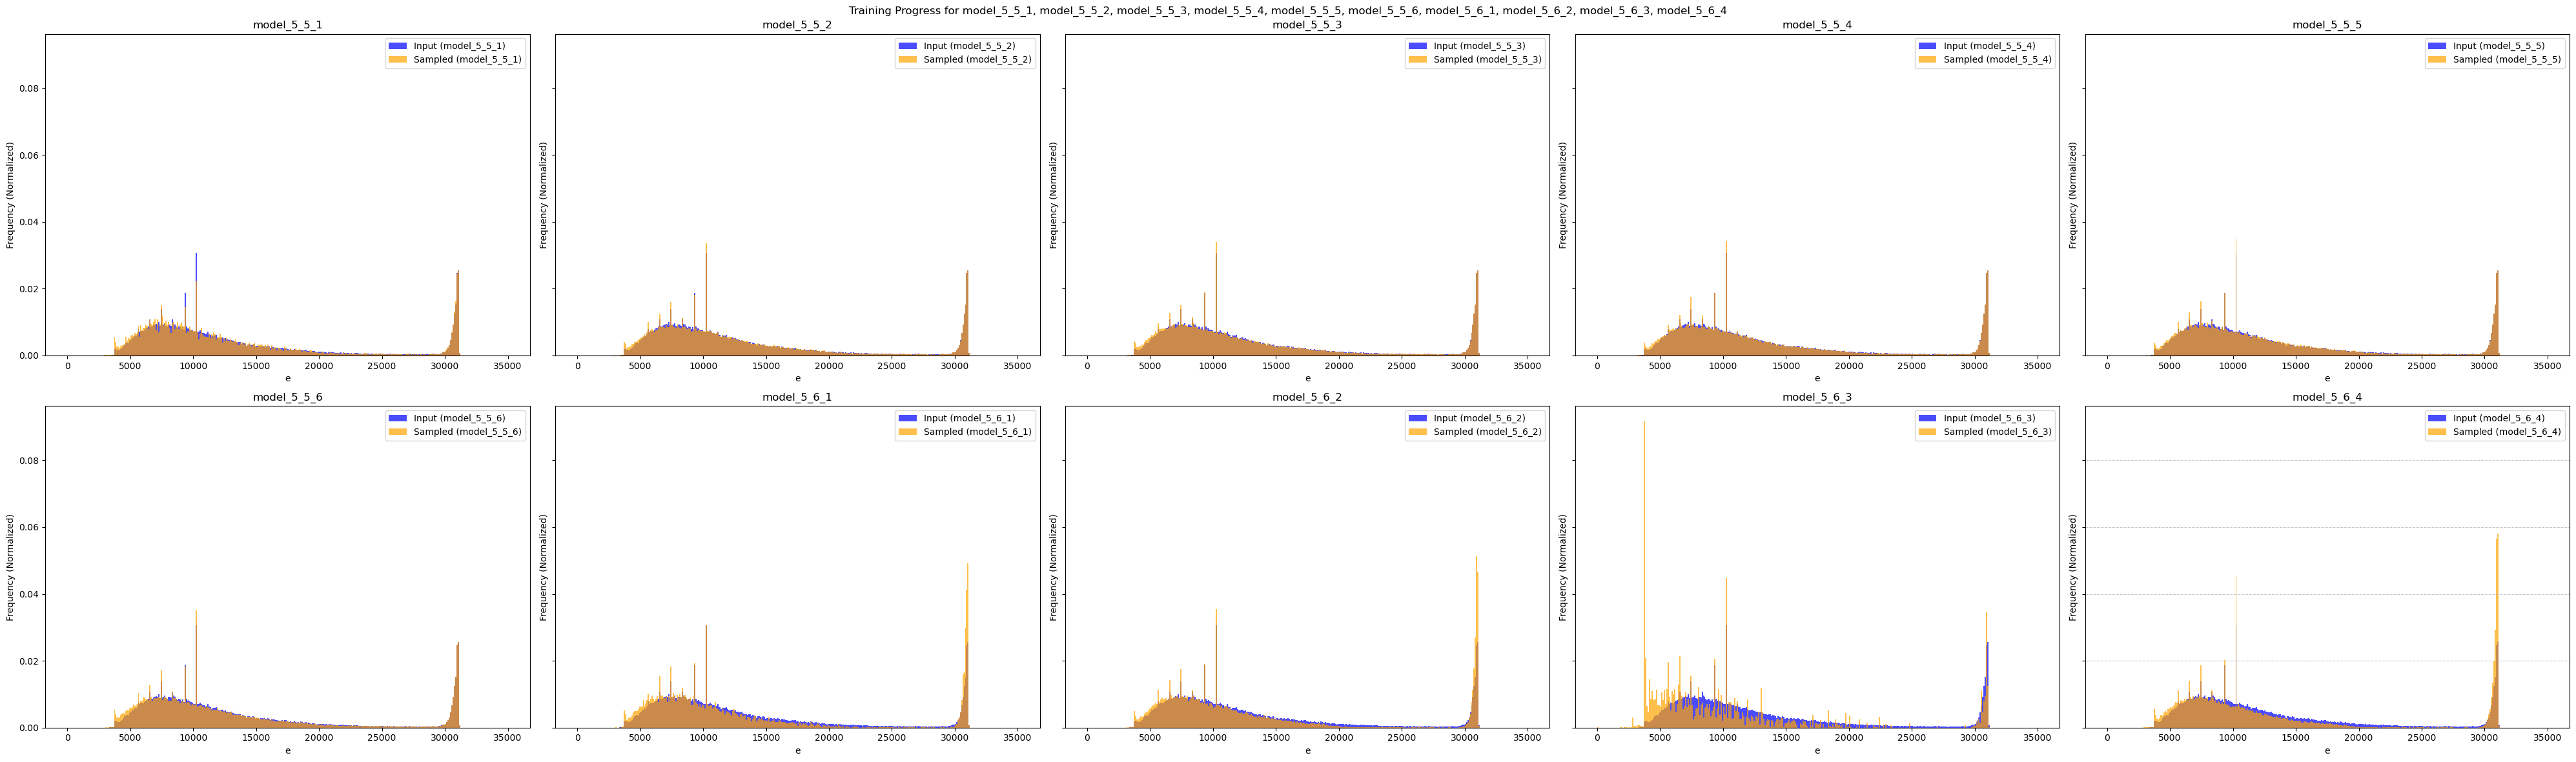

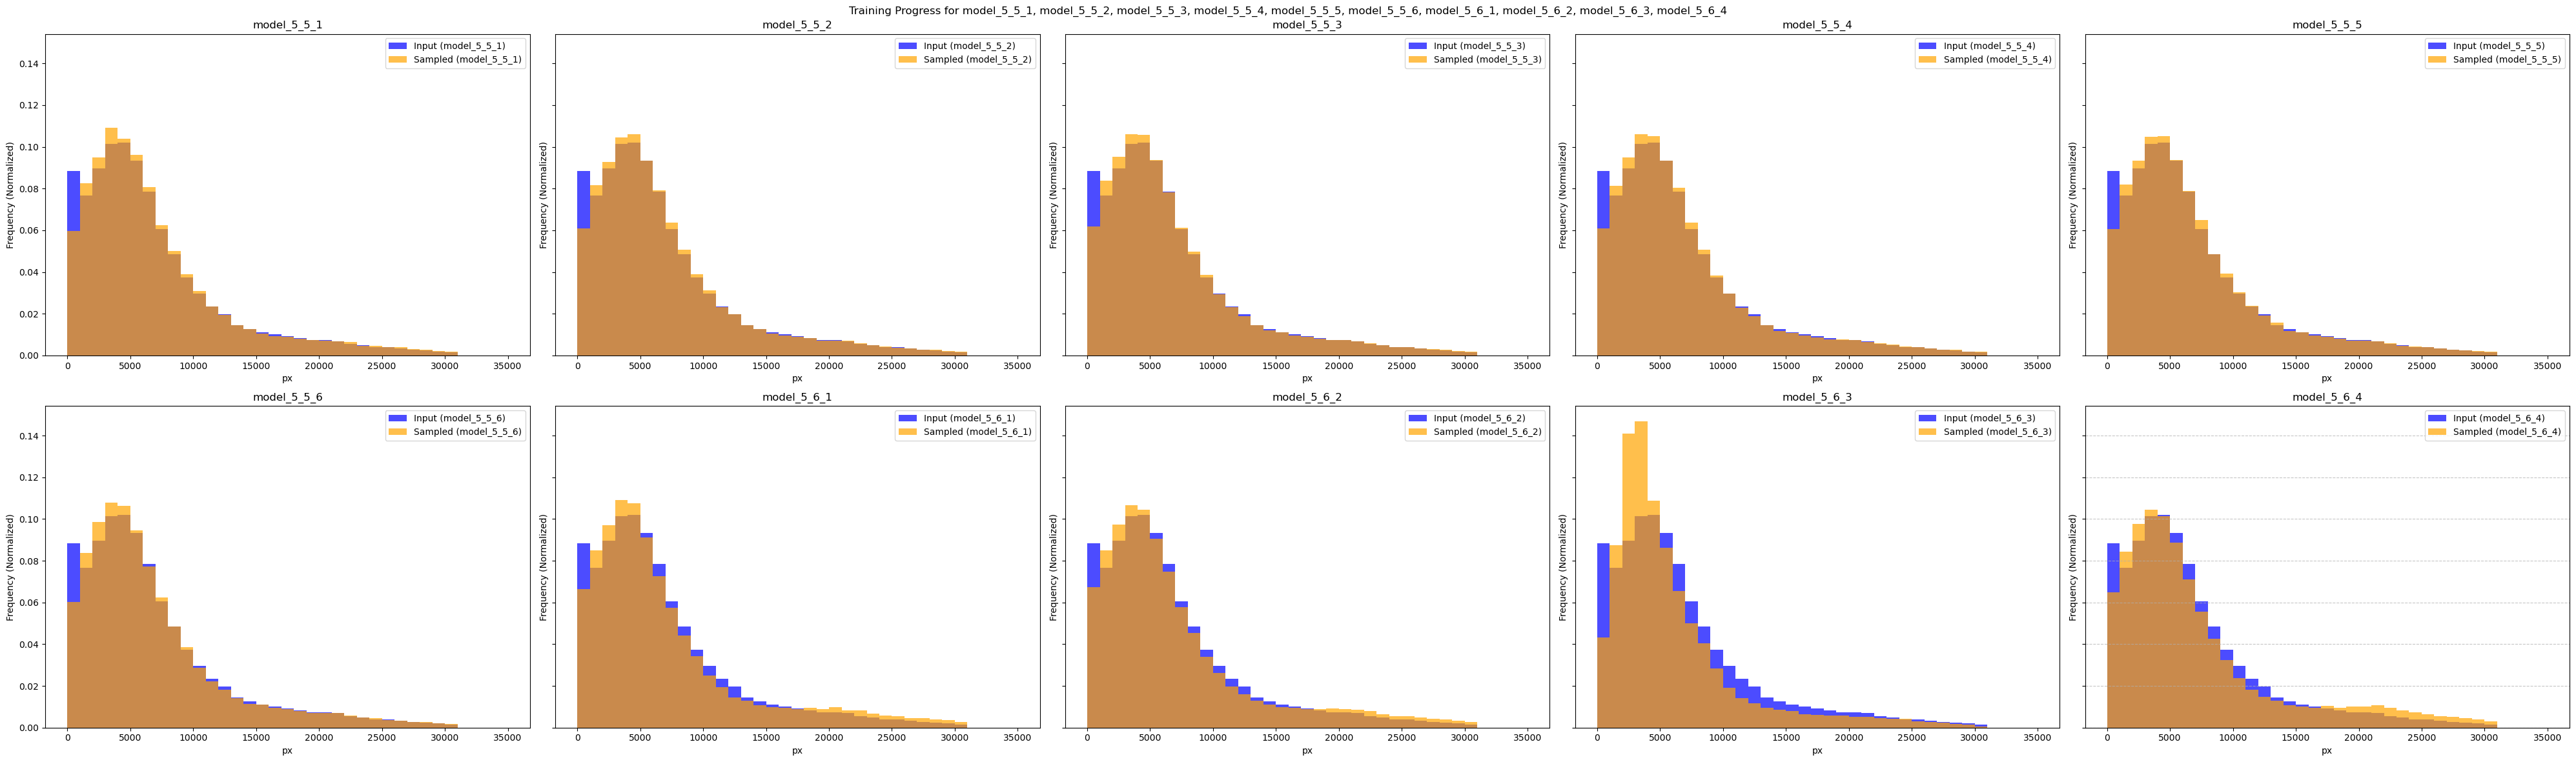

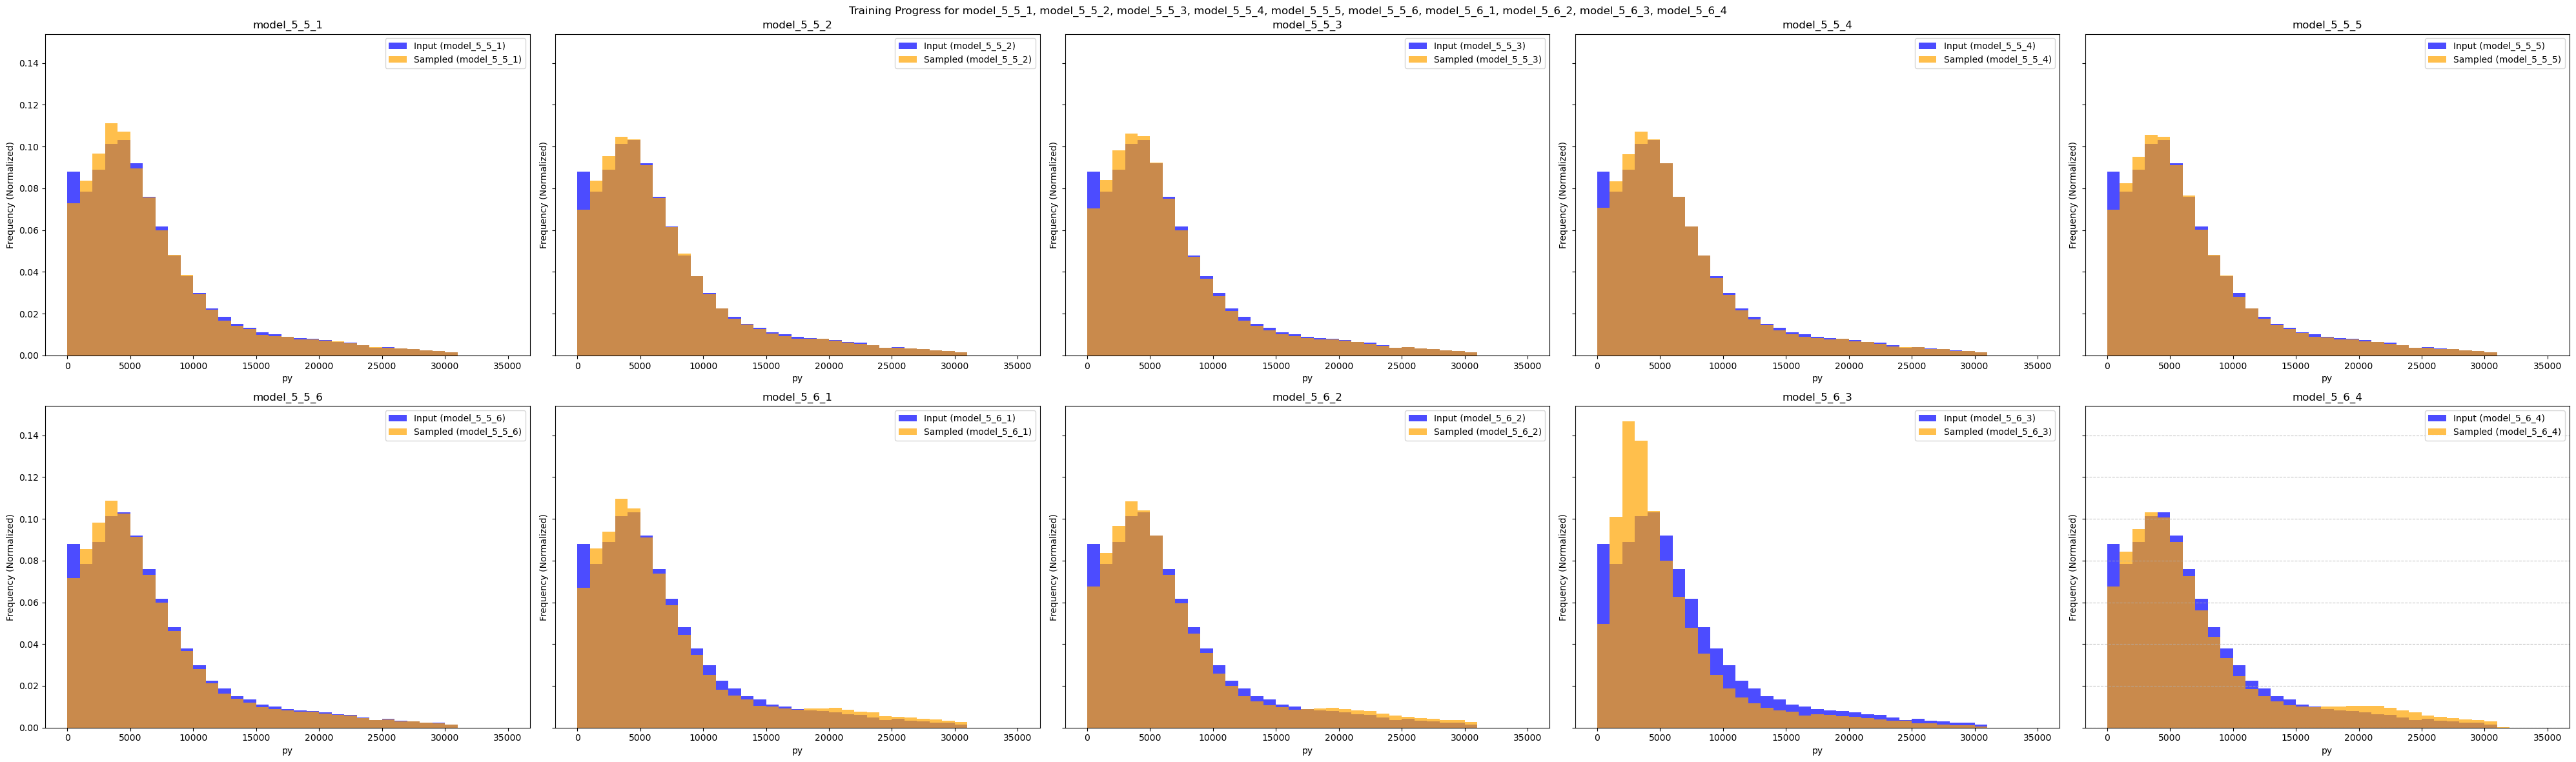

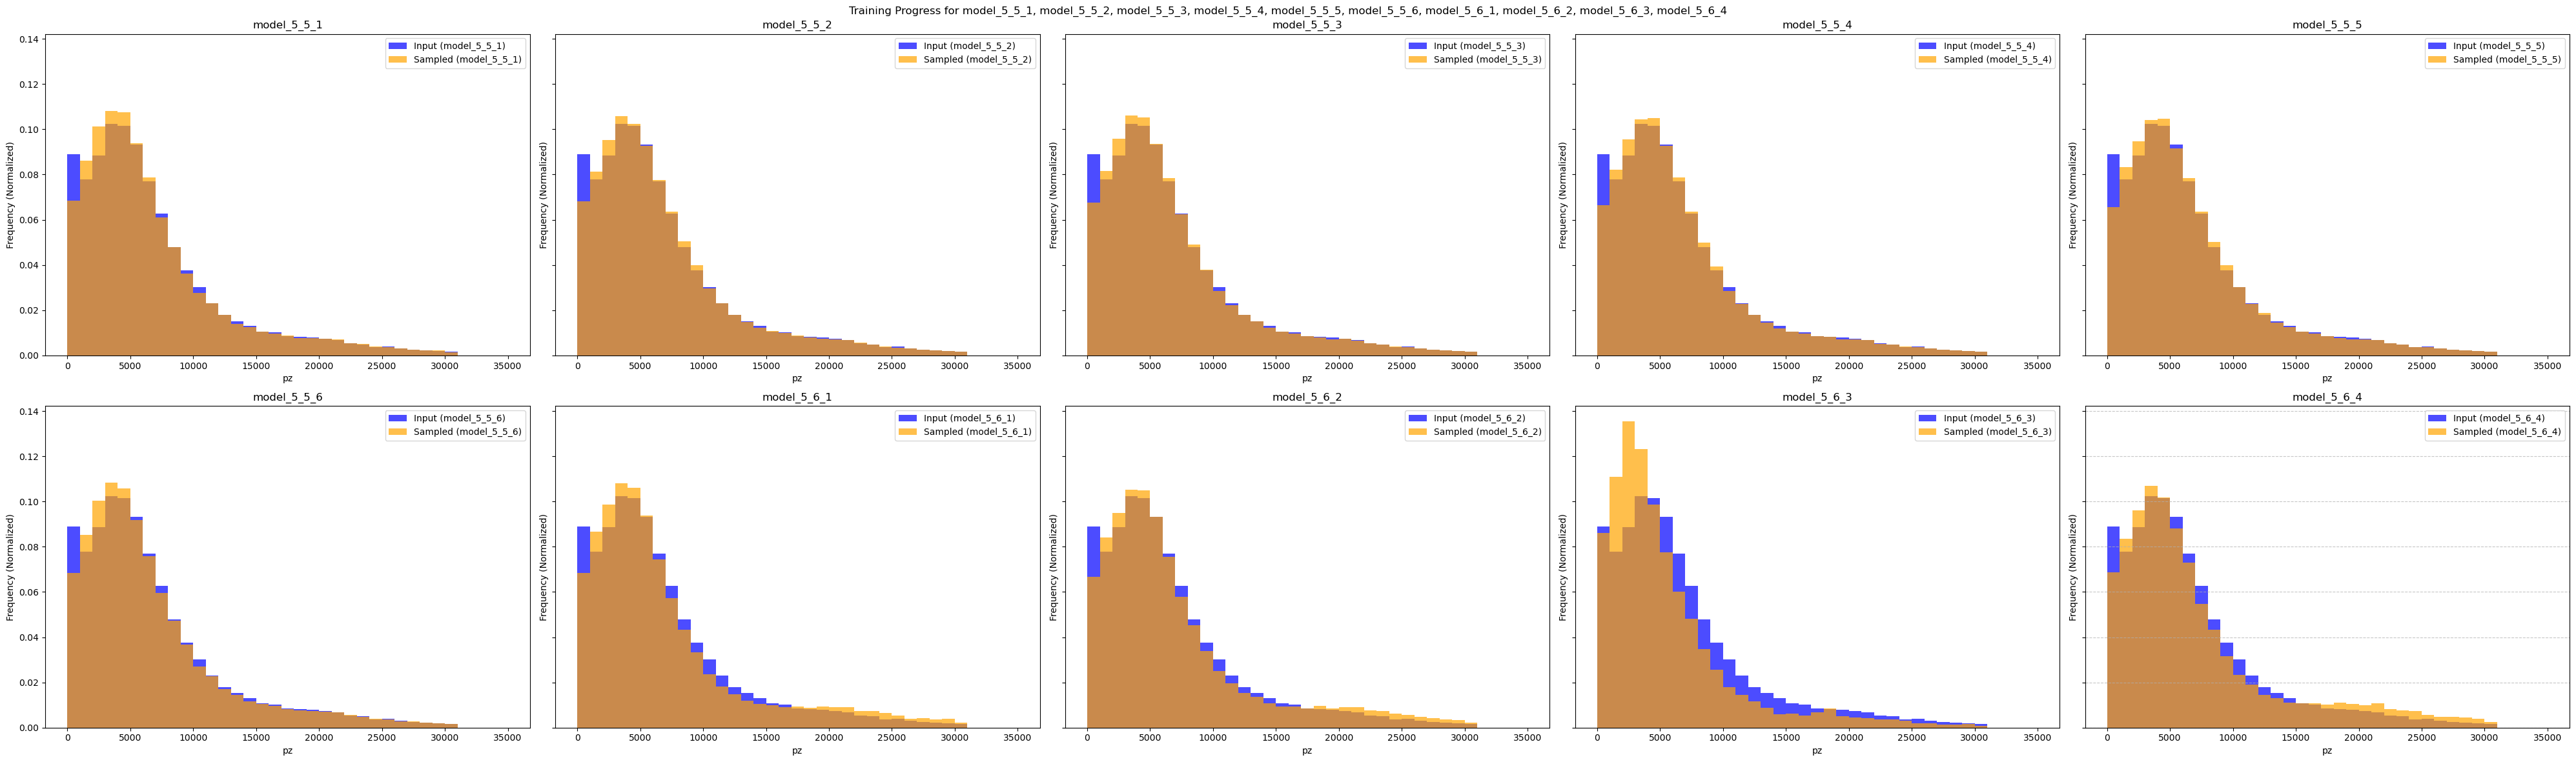

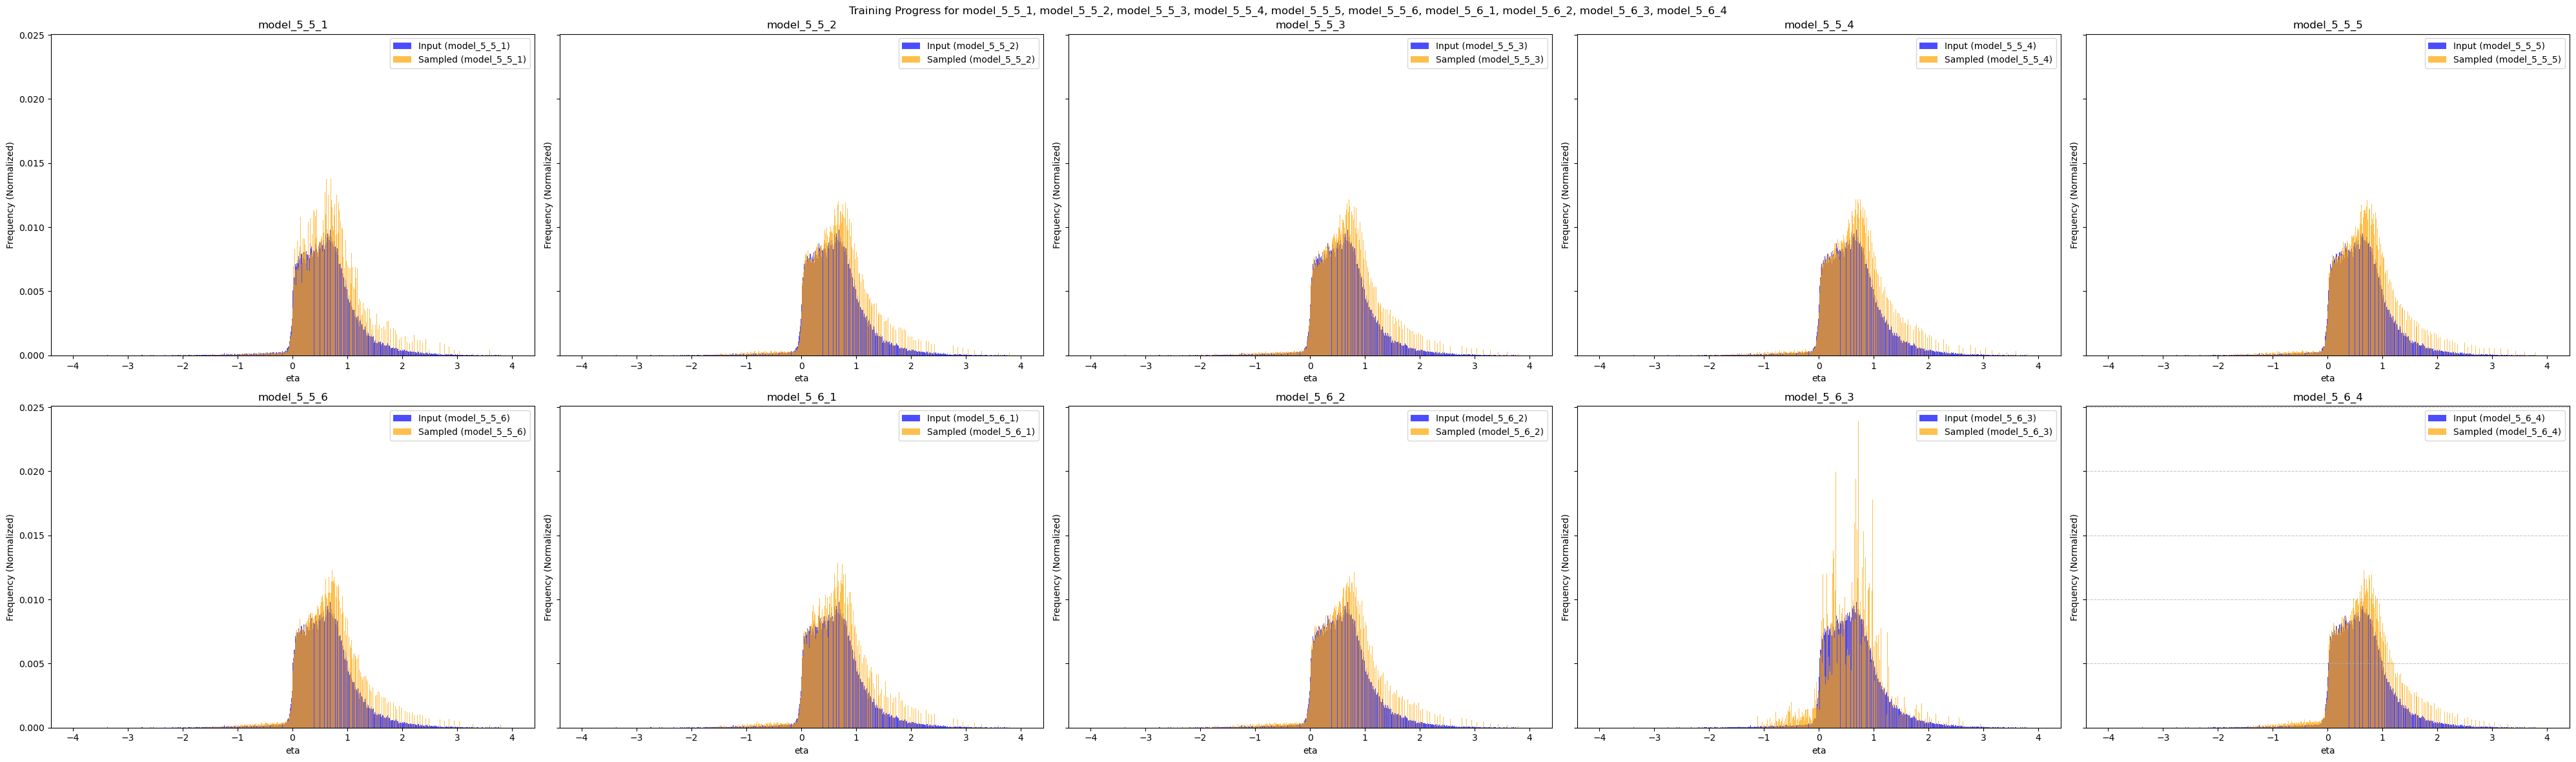

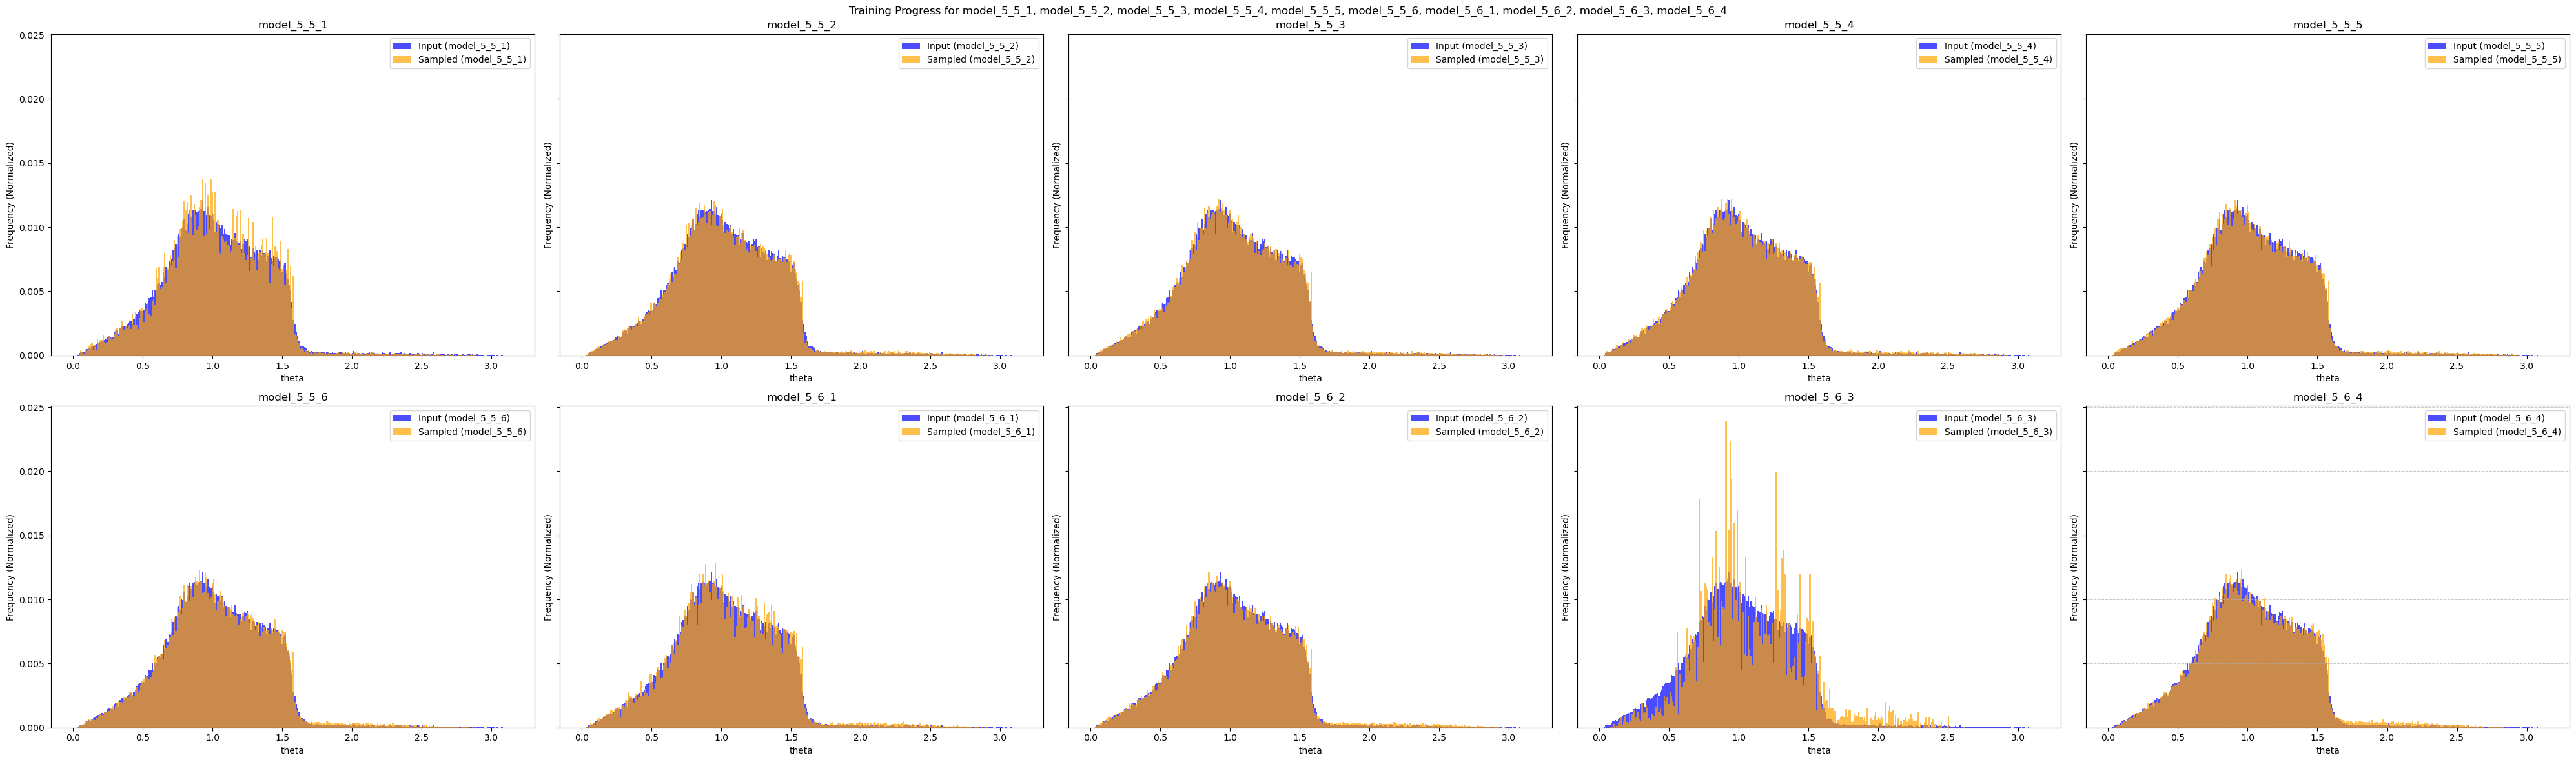

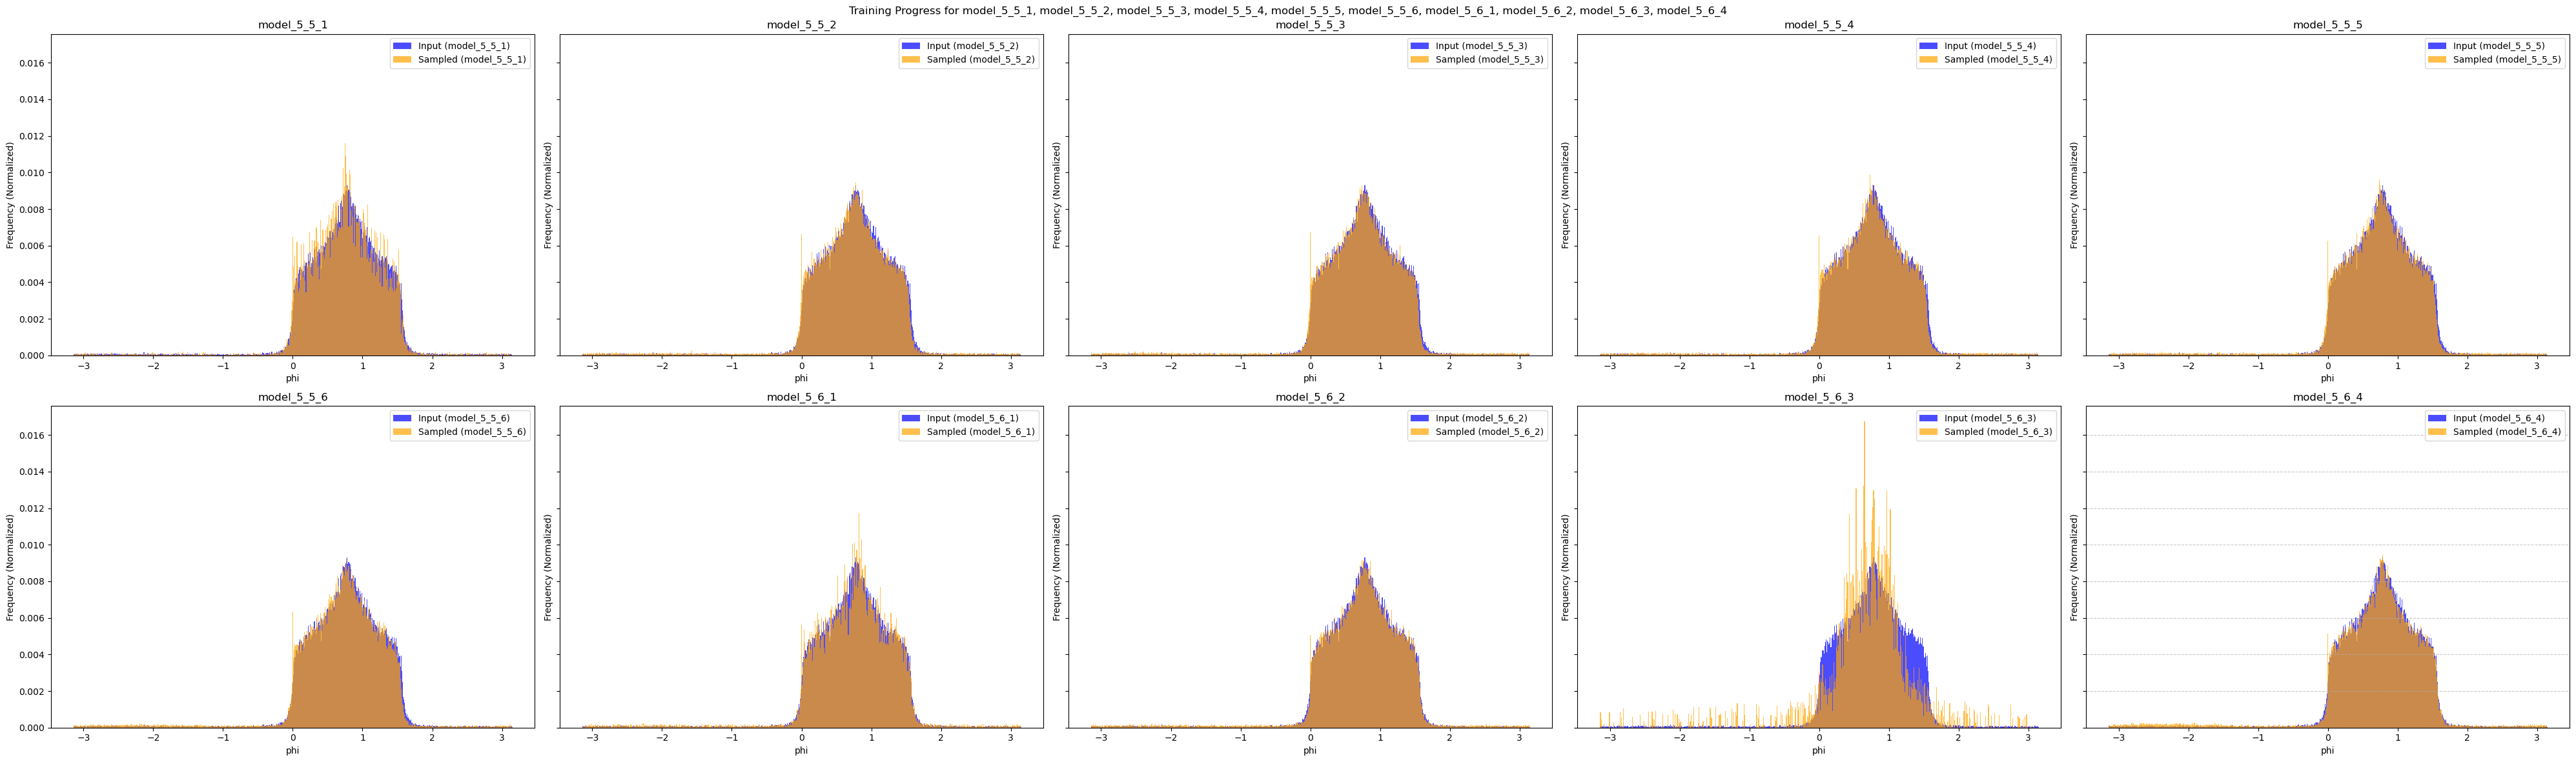

In [ ]:
all_model_names = pUtil.get_all_model_names()
df = get_default_df(all_model_names)

npb_df = df[df['scheme'] == 'no_particle_boundaries']
pv2_df = df[df['scheme'] == 'paddingv2']
# ne_df = df[df['scheme'] == 'no_eta']
display(npb_df)
display(pv2_df)

npb_models_to_compare = npb_df['model_name'].tolist()
pv2_models_to_compare = pv2_df['model_name'].tolist()

all_models_to_compare = npb_models_to_compare + pv2_models_to_compare
for column in columns:
    if column == 'pdgid':
        continue
    compare_distributions(all_models_to_compare, column_name=column, juxtaposed=True, dists_per_row=5)

## <span style="color:#db7d60">Keeping track of things</span>

In [ ]:
df = get_default_df(['model_5_6_1', 'model_5_6_2', 'model_5_6_3', 'model_5_6_4'])
df.plot(kind='scatter', x = 'learning_rate', y = 'min_saved_val_loss')
display(df)

#### This is a mega table full of everything from all the trained models.

In [ ]:
all_model_names = pUtil.get_all_model_names()
df = get_default_df(all_model_names)
df = df.applymap(lambda x: f"{x:,}" if isinstance(x, int) else x)
display(df)

In [ ]:
all_model_names = pUtil.get_all_model_names()
plot_train_graphs(all_model_names, juxtaposed=False, use_epochs=False, use_log_scale=True)

#### Create a train graph for all the models trained on 5_3.

In [ ]:
models_to_compare = [
    'model_5_3_1',
    'model_5_3_2',
    'model_5_3_3',
    'model_5_3_4',
    'model_5_3_5',
    'model_5_3_6',
    'model_5_3_7',
    'model_5_3_8',
    'model_5_3_9',
    'model_5_3_10',
    'model_5_3_11',
    'model_5_3_12',
    'model_5_3_13',
    'model_5_3_14',
    'model_5_3_15',
    'model_5_3_16',
    'model_5_3_17',
    'model_5_3_18',
    'model_5_3_19',
    'model_5_3_20',
    'model_5_3_21'
]

plot_train_graphs(models_to_compare, juxtaposed=False, use_epochs=False, use_log_scale=True)
plot_train_graphs(models_to_compare, juxtaposed=False, use_epochs=False, use_log_scale=True, y_lim=[0.7, 1])

##### Tracking models without particle boundaries. All of the 5_5 models.

In [ ]:
models_to_compare = [
    'model_5_5_1',
    'model_5_5_2',
    'model_5_5_3',
    'model_5_5_4',
    'model_5_5_5',
    'model_5_5_6'
]

plot_train_graphs(models_to_compare, juxtaposed=False, use_epochs=False, use_log_scale=True)
plot_train_graphs(models_to_compare, juxtaposed=False, use_epochs=False, use_log_scale=True, y_lim=[1, 2])
plot_train_graphs(models_to_compare, juxtaposed=False, use_epochs=False, use_log_scale=True, y_lim=[1, 1.4])

#### Tracking models without particles boundaries in the padding (paddingv2 models). All of the 5_6 models.

In [ ]:
models_to_compare = [
    'model_5_6_1',
    'model_5_6_2',
    'model_5_6_3',
    'model_5_6_4'
]

plot_train_graphs(models_to_compare, juxtaposed=False, use_epochs=False, use_log_scale=True)

#### Tracking the different scheme based models.

In [ ]:
all_model_names = pUtil.get_all_model_names()
df = get_default_df(all_model_names)
df = df.applymap(lambda x: f"{x:,}" if isinstance(x, int) else x)

df = df[df['preparation_name'].isin(['preparation_5_4', 'preparation_5_5', 'preparation_5_6'])]
df_sorted_by_min_val_loss = df.sort_values(by="min_saved_val_loss", ascending=True)

# df_sorted_by_min_val_loss = df_sorted_by_min_val_loss.style.background_gradient(cmap='RdYlGn_r', subset=['min_saved_val_loss'])

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
display(df_sorted_by_min_val_loss)

In [ ]:
all_model_names = pUtil.get_all_model_names()
df = get_default_df(all_model_names)
df = df[df['preparation_name'].isin(['preparation_5_4', 'preparation_5_5', 'preparation_5_6'])]
model_names_list = df['model_name'].tolist()
plot_train_graphs(model_names_list, juxtaposed=False, use_epochs=False, use_log_scale=True)

#### This is to check the relationship between val loss and the distributions.

Basically, even though the val loss is high after some changes* I think the distributions will be fine. This portion will be used to compare both the distributions visually and also the metrics.
* Changes meaning the type embedding and ignoring the padding token.

In [ ]:
models_to_compare = ['model_5_3_22', 'model_5_5_4', 'model_5_5_5', 'model_5_5_6', 'model_5_6_1', 'model_5_6_2', 'model_5_6_3', 'model_5_6_4']
df = get_default_df(models_to_compare)
df = df.applymap(lambda x: f"{x:,}" if isinstance(x, int) else x)

df_sorted_by_min_val_loss = df.sort_values(by="min_saved_val_loss", ascending=True)
display(df_sorted_by_min_val_loss)

plot_train_graphs(models_to_compare, juxtaposed=False, use_epochs=False, use_log_scale=True)

models_to_compare = ['model_5_3_22', 'model_5_5_6', 'model_5_6_2', 'model_5_6_4']
for column in columns:
    if column == 'pdgid':
        continue
    compare_distributions(models_to_compare, column_name=column, juxtaposed=True, dists_per_row=5)

#### Distributions for no_particle_boundaries scheme